In [7]:
import pandas as pd
import numpy as np

data_kpis = pd.read_csv("data/kpis.csv")
gh_8 = pd.read_csv("data/gh_8.csv")

# data_kpis

In [8]:
# DELETE GH 8
# data_kpis = data_kpis[~data_kpis["ent"].isin(gh_8["EENTIDAD"])]

In [9]:
start = 2015
end = 2015
data = data_kpis[(data_kpis["per"]>=start)&(data_kpis["per"]<=end)]

In [10]:
data = data.drop(columns="per")
data = data.replace(0, np.nan).groupby(["ent", "ind"]).mean("val").reset_index()
# data

In [23]:
data_pivot = data.pivot(index="ent", columns="ind", values="val").fillna(0).reset_index()
# data_pivot

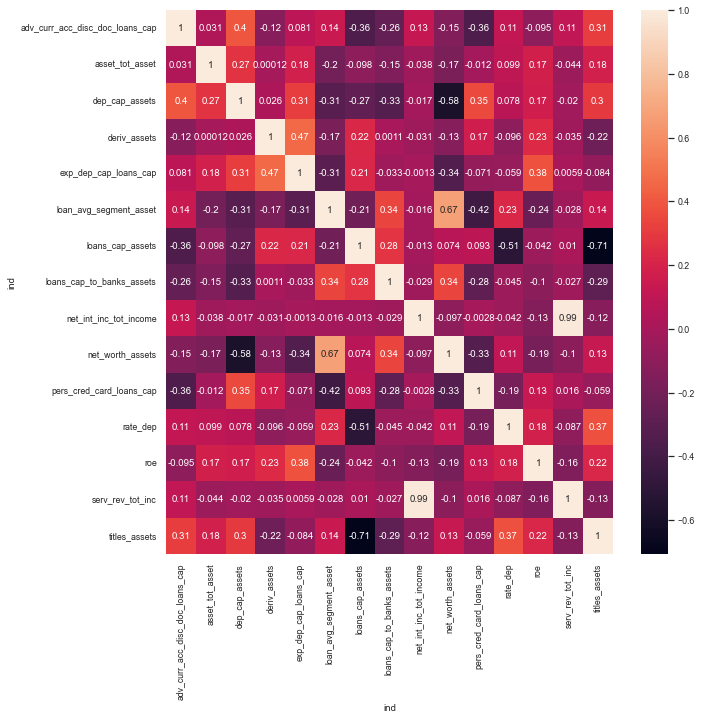

ind,adv_curr_acc_disc_doc_loans_cap,asset_tot_asset,dep_cap_assets,deriv_assets,exp_dep_cap_loans_cap,loan_avg_segment_asset,loans_cap_assets,loans_cap_to_banks_assets,net_int_inc_tot_income,net_worth_assets,pers_cred_card_loans_cap,rate_dep,roe,serv_rev_tot_inc,titles_assets
ind,,,,,,,,,,,,,,,
adv_curr_acc_disc_doc_loans_cap,1.000000,0.031406,0.399000,-0.120154,0.081090,0.135811,-0.357612,-0.264041,0.126420,-0.145769,-0.356153,0.113828,-0.095256,0.105096,0.312413
asset_tot_asset,0.031406,1.000000,0.270125,0.000117,0.183974,-0.200034,-0.097921,-0.153361,-0.038192,-0.167987,-0.011733,0.099111,0.174796,-0.044404,0.183487
dep_cap_assets,0.399000,0.270125,1.000000,0.025804,0.307146,-0.307677,-0.272566,-0.327797,-0.017363,-0.583824,0.353637,0.077911,0.169502,-0.020469,0.297938
deriv_assets,-0.120154,0.000117,0.025804,1.000000,0.466450,-0.168409,0.222583,0.001136,-0.030719,-0.128809,0.173265,-0.095834,0.230027,-0.034664,-0.220046
exp_dep_cap_loans_cap,0.081090,0.183974,0.307146,0.466450,1.000000,-0.305335,0.214036,-0.033024,-0.001323,-0.339604,-0.071259,-0.059400,0.382214,0.005892,-0.084152
loan_avg_segment_asset,0.135811,-0.200034,-0.307677,-0.168409,-0.305335,1.000000,-0.213472,0.336537,-0.016404,0.668123,-0.422968,0.225680,-0.240504,-0.027785,0.138542
loans_cap_assets,-0.357612,-0.097921,-0.272566,0.222583,0.214036,-0.213472,1.000000,0.279968,-0.013105,0.073748,0.092877,-0.511094,-0.042101,0.010152,-0.705498
loans_cap_to_banks_assets,-0.264041,-0.153361,-0.327797,0.001136,-0.033024,0.336537,0.279968,1.000000,-0.028608,0.338327,-0.280323,-0.044923,-0.100478,-0.027371,-0.286742
net_int_inc_tot_income,0.126420,-0.038192,-0.017363,-0.030719,-0.001323,-0.016404,-0.013105,-0.028608,1.000000,-0.097408,-0.002844,-0.041982,-0.134085,0.990595,-0.124940


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_mtx = data_pivot[data_pivot.columns[1:]].corr()


sns.set(font_scale=0.8, rc={"figure.figsize":(10,10)})
sns.heatmap(corr_mtx, annot=True)
plt.show()

'''plt.matshow(corr_mtx)
plt.xticks(range(data_pivot[data_pivot.columns[1:]].select_dtypes(["number"]).shape[1]), data_pivot[data_pivot.columns[1:]].select_dtypes(["number"]).columns, fontsize=10, rotation=90)
plt.yticks(range(data_pivot[data_pivot.columns[1:]].select_dtypes(["number"]).shape[1]), data_pivot[data_pivot.columns[1:]].select_dtypes(["number"]).columns, fontsize=10, rotation=45)
plt.show()'''

corr_mtx.style.background_gradient(cmap="coolwarm")

In [150]:
# importing minmax scaler 
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, MaxAbsScaler

maxabs_scaler = MaxAbsScaler()
robust_scaler = RobustScaler()
data_scaled = data_pivot
data_scaled[data_scaled.columns[1:]] = robust_scaler.fit_transform(data_scaled[data_scaled.columns[1:]])
data_scaled
for col in data_scaled:
    display(f"{col} -> MAX VALUE:{max(data_scaled[col])}, MIN VALUE:{min(data_scaled[col])}")

'ent -> MAX VALUE:65203, MIN VALUE:7'

'adv_curr_acc_disc_doc_loans_cap -> MAX VALUE:1.5073256666138632, MIN VALUE:-0.7500232075364788'

'asset_tot_asset -> MAX VALUE:18.004185154763693, MIN VALUE:-0.21724634462025935'

'dep_cap_assets -> MAX VALUE:0.6060867695047277, MIN VALUE:-2.5776408830431277'

'deriv_assets -> MAX VALUE:92.9296109047327, MIN VALUE:-151.44488170893598'

'exp_dep_cap_loans_cap -> MAX VALUE:1.8076369929614335, MIN VALUE:-18.417699138286874'

'loan_avg_segment_asset -> MAX VALUE:10.207095679759915, MIN VALUE:-0.33707673452849063'

'loans_cap_assets -> MAX VALUE:1.7109146128598012, MIN VALUE:-2.009073994554456'

'loans_cap_to_banks_assets -> MAX VALUE:11.783945256072434, MIN VALUE:-0.2605871098959587'

'net_int_inc_tot_income -> MAX VALUE:320.2461005853255, MIN VALUE:-58.33257684691272'

'net_worth_assets -> MAX VALUE:9.585720632524241, MIN VALUE:-1.4683748682363826'

'pers_cred_card_loans_cap -> MAX VALUE:1.1795280872524414, MIN VALUE:-0.8862909910339759'

'rate_dep -> MAX VALUE:1.6232004265864484, MIN VALUE:-2.42330572548658'

'roe -> MAX VALUE:2.43221775259742, MIN VALUE:-3.165861656902358'

'serv_rev_tot_inc -> MAX VALUE:239.79746968731757, MIN VALUE:-19.167679798793976'

'titles_assets -> MAX VALUE:3.278234153128302, MIN VALUE:-1.1074122822502188'

'LOF -> MAX VALUE:0.24931481652035056, MIN VALUE:-30.967959925678954'

In [153]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
data_arr = data_scaled[data_scaled.columns[1:]].to_numpy()
data_arr.shape

(61, 16)

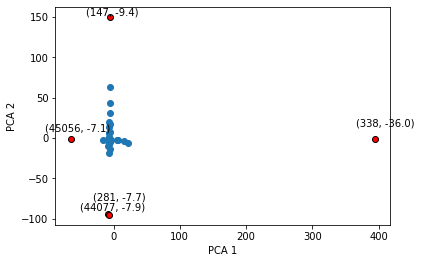

In [154]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, metric="manhattan", contamination=0.02)
clf.fit_predict(data_arr)
results = clf.negative_outlier_factor_
data_scaled["LOF"] = results

# display(data_scaled.sort_values(by="LOF").head(10))

data_pca = PCA(n_components=2).fit_transform(data_arr)
data_pca = pd.DataFrame(data_pca, columns=["pca1", "pca2"])
df_concat = data_scaled[["ent", "LOF"]]
data_pca = pd.concat([df_concat, data_pca], axis=1)
# display(data_pca)

from random import seed
from random import random

seed(1)
thr = -7
plt.scatter(data_pca["pca1"].loc[(data_pca["LOF"]>thr)], data_pca["pca2"].loc[(data_pca["LOF"]>thr)])
for i in data_pca["pca1"].loc[(data_pca["LOF"]<=thr)]:
    c = random() * 20
    plt.scatter(i, data_pca["pca2"].loc[data_pca["pca1"]==i], edgecolors="black", color="red") # data_pca["pca1"].loc[(data_pca["LOF"]<=thr)], data_pca["pca2"].loc[(data_pca["LOF"]<=thr)], edgecolors="black", color="red")
    plt.text(i+c, data_pca["pca2"].loc[data_pca["pca1"]==i]+c, 
            ([e for e in data_pca["ent"].loc[data_pca["pca1"]==i]][0], round(float([d for d in data_pca["LOF"].loc[data_pca["pca1"]==i]][0]), 1)), ha="center")
    # print(c)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

df_lof = data_scaled[data_scaled["LOF"]>-7]
# df_lof

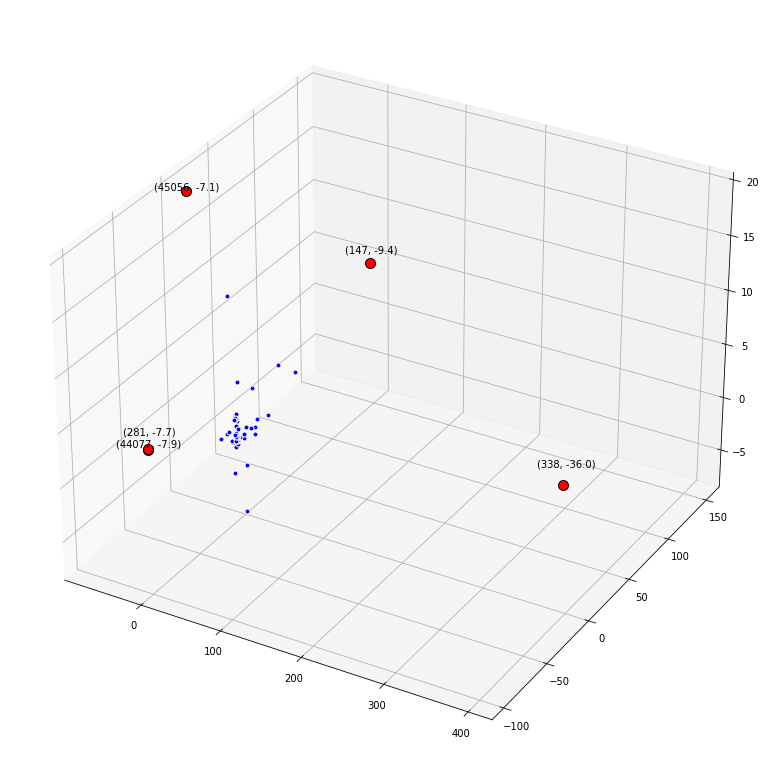

In [155]:
# — — — — — — -Setting Up Color Codes — — — — — — — — — — — -
# colors_plot = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(labels))]

df_pca3_lof = PCA(n_components=3).fit_transform(data_arr)
df_pca3_lof = pd.DataFrame(df_pca3_lof, columns=["pca1", "pca2", "pca3"])
df_concat = data_scaled[["ent", "LOF"]]
df_pca3_lof = pd.concat([df_concat, df_pca3_lof], axis=1)

thr = -7

fig = plt.figure(figsize = (20, 14))
ax = plt.axes(projection ="3d")

for k in range(len(df_pca3_lof)):
    
    ent = df_pca3_lof["ent"].loc[k]
    lof = df_pca3_lof["LOF"].loc[k]
    pca1 = df_pca3_lof["pca1"].loc[k]
    pca2 = df_pca3_lof["pca2"].loc[k]
    pca3 = df_pca3_lof["pca3"].loc[k]


    # kmeans_cc1 = df_clust["kmeans_cc1"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    # kmeans_cc2 = df_clust["kmeans_cc2"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    # kmeans_cc3 = df_clust["kmeans_cc3"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]

    if lof <= thr:
    
        ax.plot(
                    pca1,
                    pca2,
                    pca3,
                    "o",
                    markerfacecolor="red",
                    markeredgecolor="black",
                    markersize=10,
                )

        c = random() * 2
        ax.text(pca1+c, pca2+c, pca3+c, (ent, round(float(lof), 1)), ha="center")

        '''# — — — — — — -Annotate Centroids — — — — — — — — — — — -
        ax.plot(
                    kmeans_cc1,
                    kmeans_cc2,
                    kmeans_cc3,
                    "o",
                    markerfacecolor=color,
                    markeredgecolor="k",
                    markersize=10,
                )'''

    else:

        ax.plot(
                    pca1,
                    pca2,
                    pca3,
                    "o",
                    markerfacecolor="blue",
                    markeredgecolor="white",
                    markersize=5,
                )
# — — — — — — -Add title to the plot — — — — — — — — — — — -
# plt.title("KMeans with PCA - OUTLIERS not graphed", fontsize=14)
plt.show()

df_pca3_lof = df_pca3_lof[df_pca3_lof["LOF"]>thr].drop("LOF", axis=1)
# df_pca3_lof

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
# Import the digits’ dataset available in sklearn.datasets package
# from sklearn.datasets import load_digits
'''“””
Instead of using all 64 attributes of the dataset, we use Principal Component Analysis (PCA) 
to reduce the dimensions of features set such that most of the useful information is covered.
“””'''
from sklearn.decomposition import PCA
''' “””
Import module for standardizing the dataset i.e. rescaling the data such that its has mean of 0 and standard deviation of 1
“””'''
from sklearn.preprocessing import RobustScaler
#Scale the data
#data_scaled = data_arr
#robust_scaler = RobustScaler().fit(data_arr)
#robust_scaler.transform(data_scaled)
'''“””
Compute number of output classes i.e. number of digits for which we have the data (here 10 (0-9))
“””'''
num_digits = 5 # len(np.unique(dataset.target)) 
data_pca = PCA(n_components=3).fit_transform(data_arr)
'''“””
PCA constructs new components by linear combinations of original features. 
‘n_components’ parameter denotes the number of newly formed components to be considered. 
fit_transform() method fits the PCA models and performs dimensionality reduction on digit_data.
“””'''
h = 0.02 #step size of the mesh 
#Minimum and maximum x-coordinates
xmin, xmax = data_pca[:, 0].min() - 1, data_pca[:, 0].max() + 1
#Minimum and maximum y-coordinates
ymin, ymax = data_pca[:, 1].min() - 1, data_pca[:, 1].max() + 1
#Minimum and maximum z-coordinates
zmin, zmax = data_pca[:, 2].min() - 1, data_pca[:, 2].max() + 1
xx, yy, zz = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h), np.arange(zmin, zmax, h))
models = [
     (
         KMedoids(metric="manhattan", n_clusters=num_digits, 
         init="heuristic", max_iter=1000),"Manhattan metric",
     ),
     (
         KMedoids(metric="euclidean", n_clusters=num_digits,  
         init="heuristic", max_iter=1000),"Euclidean metric",
     ),
     (KMedoids(metric="cosine", n_clusters=num_digits, init="heuristic", 
      max_iter=1000), "Cosine metric", ),
]
#number of rows = integer(ceiling(number of model variants/2))
num_rows = int(np.ceil(len(models) / 2.0))
#number of columns
num_cols = 3
#Clear the current figure first (if any)
plt.clf()
#Initialize dimensions of the plot
plt.figure(figsize=(15,10))
'''“””
The ‘models’ array defined in step (6) contains three tuples, each having a model variant’s parameters and its descriptive text. 
We iterate through each of the tuples, fit the data to the model and plot the results.
“””'''
for i, (model, description) in enumerate(models):
    # Fit each point in the mesh to the model
    model.fit(data_pca)
#Predict the labels for points in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
    # Put the result  into a color plot
    Z = Z.reshape(xx.shape)
#Subplot for the ith model variant
    plt.subplot(num_cols, num_rows, i + 1)
#Display the subplot
    plt.imshow(
        Z,    #data to be plotted
        interpolation="nearest",
#bounding box coordinates (left,right,bottom,top)
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,  #colormap
        aspect="auto", #aspect ratio of the axes
        origin="lower",  #set origin as lower left corner of the axes
    )
    plt.plot(
        data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], "k.", markersize=2, alpha=0.3
    )
    # Plot the centroids as white cross marks
    centroids = model.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        centroids[:, 2],
        marker="x",
        s=169,  #marker’s size (points^2)
        linewidths=3, #width of boundary lines
        color="w",  #white color for centroids markings
        zorder=10,  #drawing order of axes
    )
    #describing text of the tuple will be title of the subplot
    plt.title(description)  
    plt.xlim(xmin, xmax)  #limits of x-coordinates
    plt.ylim(ymin, ymax)  #limits of y-coordinates
    plt.ylim(zmin, zmax)  #limits of y-coordinates
    plt.xticks(())   
    plt.yticks(())
    plt.zticks(())
#Upper title of the whole plot
plt.suptitle(
#Text to be displayed
    "K-Medoids algorithm implemented with different metrics\n\n",
    fontsize=20,  #size of the fonts
)
plt.show()

MemoryError: Unable to allocate 3.63 TiB for an array with shape (12350, 23027, 1752) and data type float64

In [156]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA

# data_pca = PCA(n_components=3).fit_transform(data_arr)

# df_pca3_lof

k_med = KMedoids(metric="cosine", n_clusters=5, 
         init="heuristic", max_iter=10000, method="pam").fit(df_pca3_lof[df_pca3_lof.columns[1:]])

k_means = KMeans(n_clusters=5, n_init=100, max_iter=10000, algorithm="elkan").fit(df_pca3_lof[df_pca3_lof.columns[1:]])

y_k_med = k_med.fit_predict(df_pca3_lof[df_pca3_lof.columns[1:]])

y_k_means = k_means.fit_predict(df_pca3_lof[df_pca3_lof.columns[1:]])

kmed_labels = k_med.labels_
labels = set(kmed_labels)

kmeans_labels = k_means.labels_

In [157]:
k_med_clust = k_med.cluster_centers_ # PCA(n_components=2).fit_transform(robust_scaler.fit_transform(k_med.cluster_centers_))
k_means_clust = k_means.cluster_centers_ # PCA(n_components=2).fit_transform(robust_scaler.fit_transform(k_means.cluster_centers_))

In [158]:
df_clust = pd.DataFrame(df_pca3_lof, columns=["pca1", "pca2", "pca3"])
df_clust["ent"] = df_pca3_lof["ent"]
df_clust["kmed"] = y_k_med
df_clust["kmeans"] = y_k_means
df_clust["kmed_cc1"] = [k_med_clust[c, 0] for c in df_clust["kmed"]]
df_clust["kmed_cc2"] = [k_med_clust[c, 1] for c in df_clust["kmed"]]
df_clust["kmed_cc3"] = [k_med_clust[c, 2] for c in df_clust["kmed"]]
df_clust["kmeans_cc1"] = [k_means_clust[c, 0] for c in df_clust["kmeans"]]
df_clust["kmeans_cc2"] = [k_means_clust[c, 1] for c in df_clust["kmeans"]]
df_clust["kmeans_cc3"] = [k_means_clust[c, 2] for c in df_clust["kmeans"]]
# df_clust

In [61]:
df_explained_variance = data_pca.explained_variance_ratio_
df_explained_variance = np.insert(df_explained_variance, 0, 0)
cumulative_variance = np.cumsum(np.round(df_explained_variance, decimals=3))
pca_variance = pd.DataFrame(['', 'pc1', 'pc2', 'pc3'], columns=['pc'])
df_explained_variance = pd.DataFrame(df_explained_variance, columns=['explained_variance'])
cumulative_variance = pd.DataFrame(cumulative_variance, columns=['cumulative_variance'])
df_explained_variance = pd.concat([pca_variance, df_explained_variance, cumulative_variance], axis=1)
print(df_explained_variance)

AttributeError: 'DataFrame' object has no attribute 'explained_variance_ratio_'

In [159]:
kmed_labels = df_clust["kmed"].unique() # df_clust["ent"][df_clust["kmed"]==0]

for label in kmed_labels:
    display(df_clust[df_clust["kmed"]==label])

,pca1,pca2,pca3,ent,kmed,kmeans,kmed_cc1,kmed_cc2,kmed_cc3,kmeans_cc1,kmeans_cc2,kmeans_cc3
0,-7.007298,5.914083,-1.888959,7,2,1,-7.07025,13.541152,-1.46602,-7.024099,-2.082497,-0.610602
3,-6.879220,6.068399,-1.523904,15,2,1,-7.07025,13.541152,-1.46602,-7.024099,-2.082497,-0.610602
20,-5.914265,17.385223,-1.661620,150,2,3,-7.07025,13.541152,-1.46602,-6.216256,20.436349,-1.390956
21,-5.369742,43.323923,2.388325,165,2,2,-7.07025,13.541152,-1.46602,-5.601060,53.041802,1.427270
23,-7.070250,13.541152,-1.466020,198,2,3,-7.07025,13.541152,-1.46602,-6.216256,20.436349,-1.390956
26,-6.053540,19.533021,-1.012609,259,2,3,-7.07025,13.541152,-1.46602,-6.216256,20.436349,-1.390956
27,-5.832377,62.759682,0.466216,266,2,2,-7.07025,13.541152,-1.46602,-5.601060,53.041802,1.427270
33,-5.758290,7.227275,-0.864763,299,2,1,-7.07025,13.541152,-1.46602,-7.024099,-2.082497,-0.610602
44,-5.826969,31.285999,-1.423577,322,2,3,-7.07025,13.541152,-1.46602,-6.216256,20.436349,-1.390956


,pca1,pca2,pca3,ent,kmed,kmeans,kmed_cc1,kmed_cc2,kmed_cc3,kmeans_cc1,kmeans_cc2,kmeans_cc3
1,-7.514936,-4.578672,-4.451664,11,3,1,-7.277041,-2.677161,-1.083691,-7.024099,-2.082497,-0.610602
2,-4.999778,-2.526861,-1.831303,14,3,1,-7.277041,-2.677161,-1.083691,-7.024099,-2.082497,-0.610602
4,-7.173387,1.424296,-1.470871,16,3,1,-7.277041,-2.677161,-1.083691,-7.024099,-2.082497,-0.610602
5,-7.178048,-4.087336,-1.735603,17,3,1,-7.277041,-2.677161,-1.083691,-7.024099,-2.082497,-0.610602
6,-5.667195,-1.485977,-1.129089,20,3,1,-7.277041,-2.677161,-1.083691,-7.024099,-2.082497,-0.610602
8,-6.784324,-3.049772,-2.018084,29,3,1,-7.277041,-2.677161,-1.083691,-7.024099,-2.082497,-0.610602
11,-7.464817,-2.649272,-1.237651,45,3,1,-7.277041,-2.677161,-1.083691,-7.024099,-2.082497,-0.610602
12,-5.912011,-2.665971,-1.394464,65,3,1,-7.277041,-2.677161,-1.083691,-7.024099,-2.082497,-0.610602
13,-7.074057,-1.126906,-1.930344,72,3,1,-7.277041,-2.677161,-1.083691,-7.024099,-2.082497,-0.610602
14,-6.656863,-2.672687,-1.293661,83,3,1,-7.277041,-2.677161,-1.083691,-7.024099,-2.082497,-0.610602


,pca1,pca2,pca3,ent,kmed,kmeans,kmed_cc1,kmed_cc2,kmed_cc3,kmeans_cc1,kmeans_cc2,kmeans_cc3
7,-5.875679,-13.266490,-0.098909,27,1,4,-7.76474,-9.997084,-0.136144,-7.012539,-14.004063,-0.150257
9,-7.335748,-6.700955,-1.338163,34,1,1,-7.76474,-9.997084,-0.136144,-7.024099,-2.082497,-0.610602
10,-7.397197,-18.748614,-0.215719,44,1,4,-7.76474,-9.997084,-0.136144,-7.012539,-14.004063,-0.150257
25,-7.303179,-6.795183,-1.235855,254,1,1,-7.76474,-9.997084,-0.136144,-7.024099,-2.082497,-0.610602
30,-5.699151,-4.401838,0.735383,277,1,1,-7.76474,-9.997084,-0.136144,-7.024099,-2.082497,-0.610602
34,-7.764740,-9.997084,-0.136144,300,1,4,-7.76474,-9.997084,-0.136144,-7.012539,-14.004063,-0.150257


,pca1,pca2,pca3,ent,kmed,kmeans,kmed_cc1,kmed_cc2,kmed_cc3,kmeans_cc1,kmeans_cc2,kmeans_cc3
38,4.852223,-2.246038,-7.962761,310,0,0,6.676836,-2.924506,-3.442801,12.111747,-3.633283,-1.864006
46,15.218217,-3.102176,3.914629,331,0,0,6.676836,-2.924506,-3.442801,12.111747,-3.633283,-1.864006
53,6.676836,-2.924506,-3.442801,389,0,0,6.676836,-2.924506,-3.442801,12.111747,-3.633283,-1.864006
54,21.699713,-6.260411,0.034907,426,0,0,6.676836,-2.924506,-3.442801,12.111747,-3.633283,-1.864006


,pca1,pca2,pca3,ent,kmed,kmeans,kmed_cc1,kmed_cc2,kmed_cc3,kmeans_cc1,kmeans_cc2,kmeans_cc3
47,-4.950618,-2.637097,4.005774,332,4,1,-4.950618,-2.637097,4.005774,-7.024099,-2.082497,-0.610602
60,-15.739547,-1.900690,11.622113,65203,4,1,-4.950618,-2.637097,4.005774,-7.024099,-2.082497,-0.610602


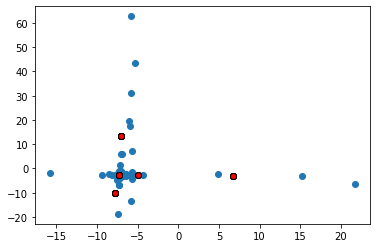

In [160]:
plt.scatter(df_clust["pca1"], df_clust["pca2"])
plt.scatter(df_clust["kmed_cc1"], df_clust["kmed_cc2"], edgecolors="black", color="red")

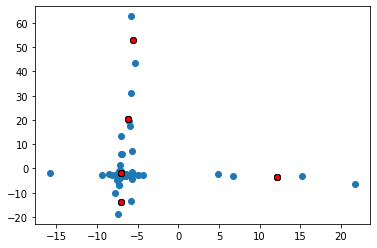

In [161]:
plt.scatter(df_clust["pca1"], df_clust["pca2"])
plt.scatter(df_clust["kmeans_cc1"], df_clust["kmeans_cc2"], edgecolors="black", color="red")

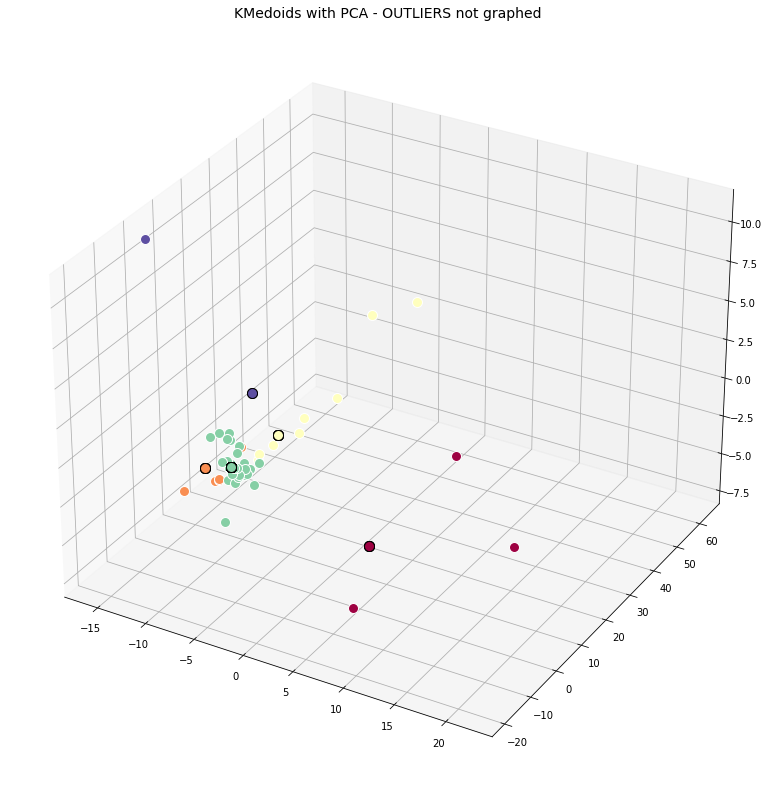

In [162]:
# — — — — — — -Setting Up Color Codes — — — — — — — — — — — -
colors_plot = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(labels))]

fig = plt.figure(figsize = (20, 14))
ax = plt.axes(projection ="3d")

for k, col in zip(labels, colors_plot):
    class_member_mask = df_clust["kmed"] == k
 
    # — — — — — — -Setting datapoint Feature X and Feature Y — — — — — — — — — — — -
    pca1 = df_clust["pca1"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    pca2 = df_clust["pca2"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    pca3 = df_clust["pca3"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]


    kmed_cc1 = df_clust["kmed_cc1"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    kmed_cc2 = df_clust["kmed_cc2"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    kmed_cc3 = df_clust["kmed_cc3"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]

    color = tuple(col)
 
    # — — — — — — -Plotting Feature X and Feature Y for each cluster labels — — — — — — — — — — — -
    ax.plot(
                pca1,
                pca2,
                pca3,
                "o",
                markerfacecolor=color,
                markeredgecolor="white",
                markersize=10,
            )

    # — — — — — — -Annotate Centroids — — — — — — — — — — — -
    ax.plot(
                kmed_cc1,
                kmed_cc2,
                kmed_cc3,
                "o",
                markerfacecolor=color,
                markeredgecolor="k",
                markersize=10,
            )
# — — — — — — -Add title to the plot — — — — — — — — — — — -
plt.title("KMedoids with PCA - OUTLIERS not graphed", fontsize=14)
plt.show()

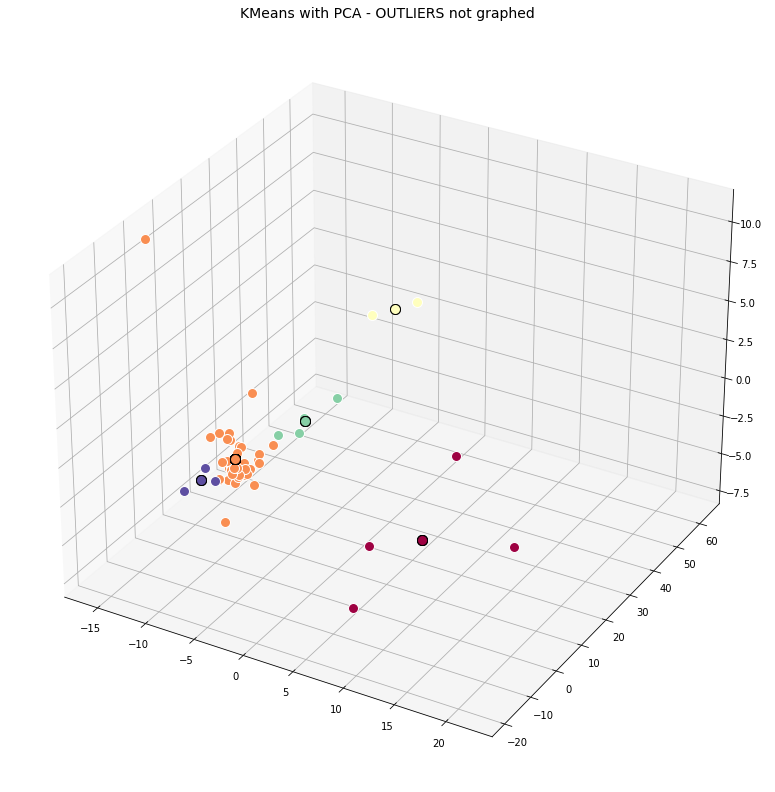

In [163]:
# — — — — — — -Setting Up Color Codes — — — — — — — — — — — -
colors_plot = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(labels))]

fig = plt.figure(figsize = (20, 14))
ax = plt.axes(projection ="3d")

for k, col in zip(labels, colors_plot):
    class_member_mask = df_clust["kmeans"] == k
 
    # — — — — — — -Setting datapoint Feature X and Feature Y — — — — — — — — — — — -
    pca1 = df_clust["pca1"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    pca2 = df_clust["pca2"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    pca3 = df_clust["pca3"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]


    kmeans_cc1 = df_clust["kmeans_cc1"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    kmeans_cc2 = df_clust["kmeans_cc2"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]
    kmeans_cc3 = df_clust["kmeans_cc3"][class_member_mask]#.loc[(df_clust["pca1"]<=10)&(df_clust["pca2"]<=10)]

    color = tuple(col)
 
    # — — — — — — -Plotting Feature X and Feature Y for each cluster labels — — — — — — — — — — — -
    ax.plot(
                pca1,
                pca2,
                pca3,
                "o",
                markerfacecolor=color,
                markeredgecolor="white",
                markersize=10,
            )

    # — — — — — — -Annotate Centroids — — — — — — — — — — — -
    ax.plot(
                kmeans_cc1,
                kmeans_cc2,
                kmeans_cc3,
                "o",
                markerfacecolor=color,
                markeredgecolor="k",
                markersize=10,
            )
# — — — — — — -Add title to the plot — — — — — — — — — — — -
plt.title("KMeans with PCA - OUTLIERS not graphed", fontsize=14)
plt.show()

In [81]:
y_k_med

array([0, 2, 2, 0, 1, 5, 4, 6, 5, 2, 6, 5, 3, 4, 5, 5, 5, 5, 5, 0, 0, 0,
       5, 0, 3, 2, 0, 0, 5, 3, 2, 6, 4, 0, 2, 3, 3, 3, 7, 5, 7, 3, 5, 5,
       0, 4, 6, 2, 7, 6, 3, 5, 5, 6, 6, 4, 4, 6, 1, 5, 1], dtype=int64)

In [82]:
k_med.inertia_

5.202566220161659

In [83]:
from sklearn.metrics import silhouette_samples, silhouette_score
silhouette_avg = silhouette_score(data_arr, y_k_med)
print(silhouette_avg)

-0.15578300889414456


In [84]:
sample_silhouette_values = silhouette_samples(data_pca, y_k_med)
for i in range(3):
    ith_cluster_silhouette_values = sample_silhouette_values[y_k_med == i]
    print(np.mean(ith_cluster_silhouette_values))

-0.26540364230176705
-0.492948967054438
-0.11577493312983726
